In [88]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_absolute_error
import seaborn as sns
sns.set_theme()

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

#### 1. Загрузка данных и первичный анализ

In [89]:
df = pd.read_csv('./AirPassengers.csv', sep =',', parse_dates=['Month'], index_col='Month')
df.sort_index(inplace=True)
df = df.rename(columns={'#Passengers':'passengers', 'Month':'datetime'})
df

,passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


<Axes: title={'center': 'N of passengers change over time'}, xlabel='Month'>

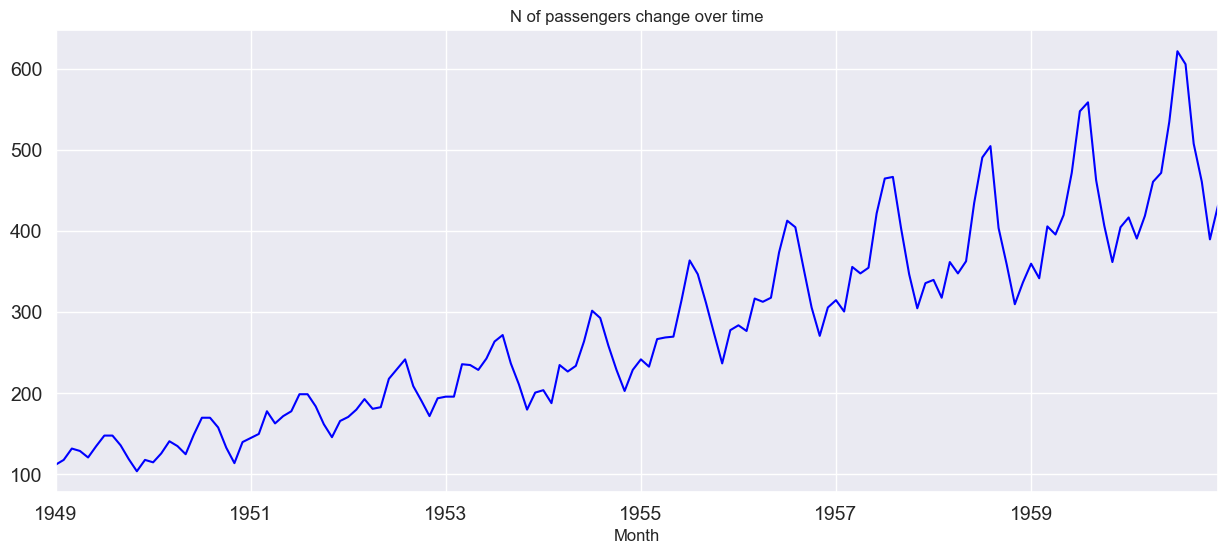

In [90]:
df.passengers.plot(
    figsize=(15,6),
    title= 'N of passengers change over time', 
    fontsize=14, 
    color="blue")

#### 2. Первоначальные выводы о тренде и сезонности

1. По графику видно что наблюдается возрастающий **тренд** (увеличение количества пассажиров авиа-линий ), а также наблюдается **сезонность** в наших данных.
2. Если говорить о **тренде**, то его увеличению на мой взгляд способствует снижение цен за билет и общедоступность полетов на самолете. Так мы наблюдаем за временными рядами, раньше только состоятельные имели доступ к лимитированному доступу полетов и т п. Что касается **сезонности**, то скорее всего если внимательно взглянуть на график, то можно заметить высокую точку которая расположена в середине между двумя годами, то есть летом. Т к летом больше всего полетов, то из этого следует что люди летят на отдых, в курорты и т п, в общем отдыхать. 

#### 3. Сглаживание шума

In [91]:
window_size = 7
df['smoothed'] = df.passengers.rolling(window=window_size).mean()

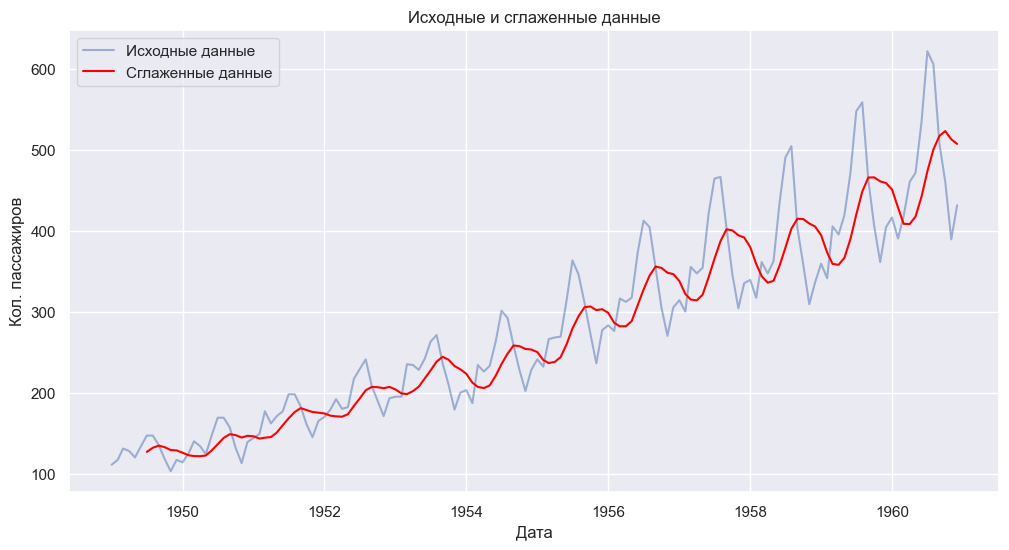

In [92]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df.passengers, label='Исходные данные', alpha=0.5)
plt.plot(df.index, df.smoothed, label='Сглаженные данные', color='red')
plt.title('Исходные и сглаженные данные')
plt.xlabel('Дата')
plt.ylabel('Кол. пассажиров')
plt.legend()
plt.show()

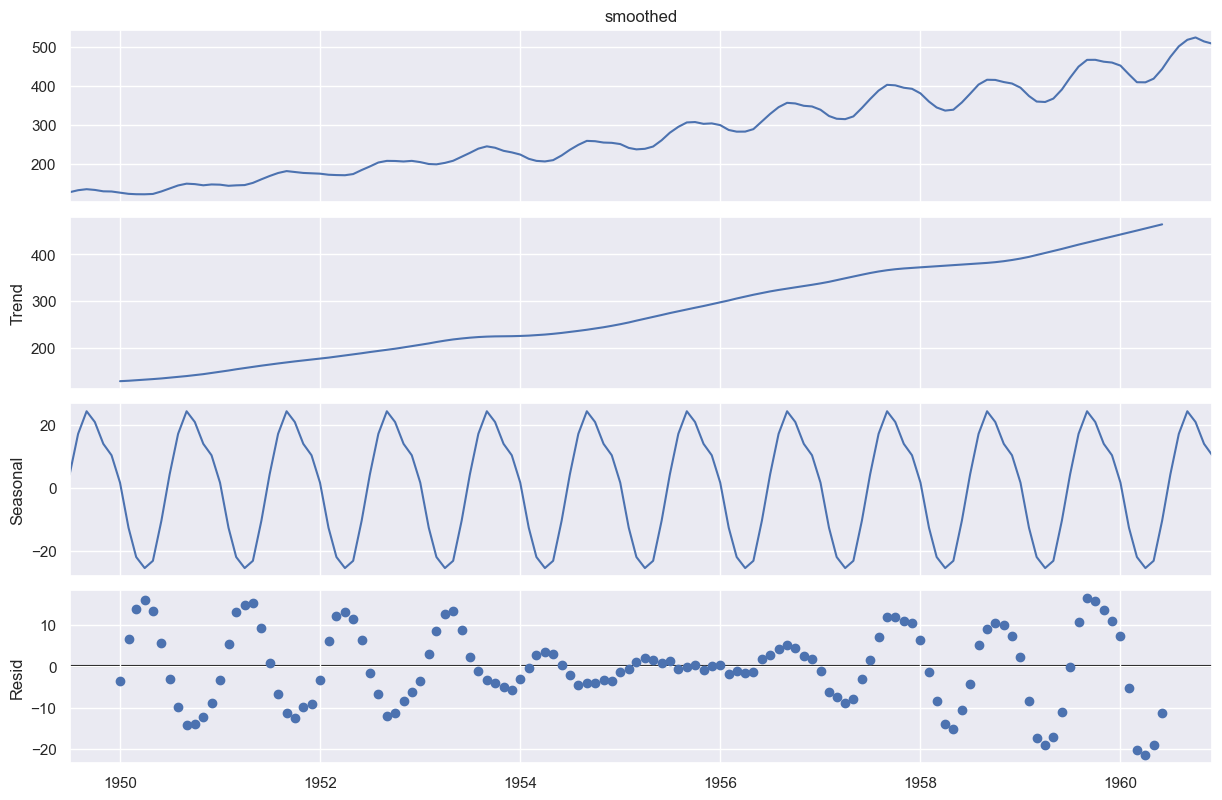

In [93]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df.smoothed.dropna(), model='additive')
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

Как видим, есть сезонность и есть тренд

#### 4. Анализ сезонности на разных временных интервалах

In [94]:
df['month'] = df.index.month
df['quarter'] = df.index.quarter
df['year'] = df.index.year
df_pivot = pd.pivot_table(df, values = "passengers", columns = "year", index = "month")
df.head(7)

,passengers,smoothed,month,quarter,year
Month,,,,,
1949-01-01,112,NaN,1,1,1949
1949-02-01,118,NaN,2,1,1949
1949-03-01,132,NaN,3,1,1949
1949-04-01,129,NaN,4,2,1949
1949-05-01,121,NaN,5,2,1949
1949-06-01,135,NaN,6,2,1949
1949-07-01,148,127.857143,7,3,1949


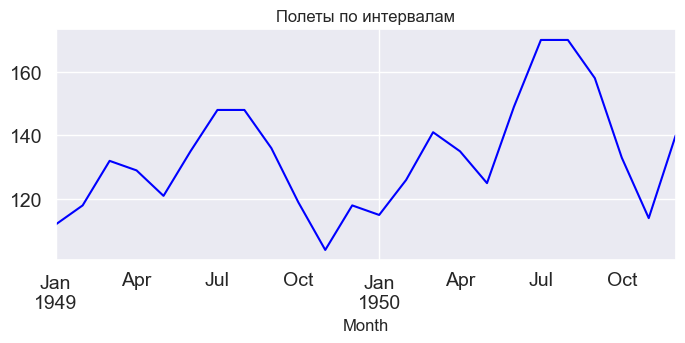

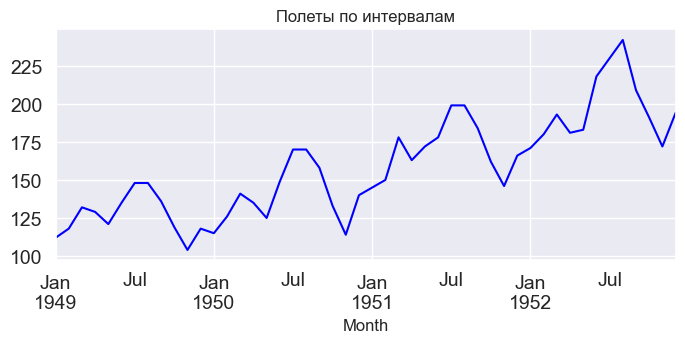

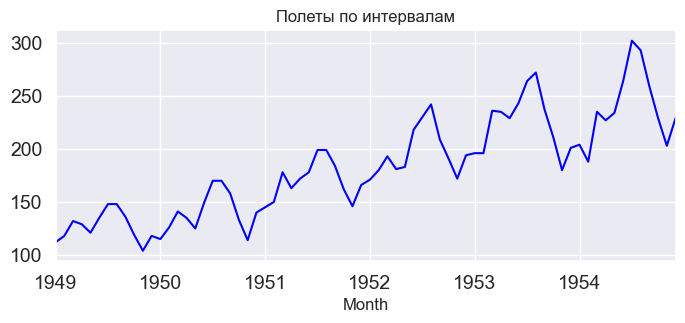

In [95]:
for intervals in range(1, 4):
    df.iloc[:24 * intervals].passengers.plot( figsize=(8,3),title= 'Полеты по интервалам', fontsize=14, color="blue")
    plt.show()

#### 5. Анализ тренда с использованием скользящих средних

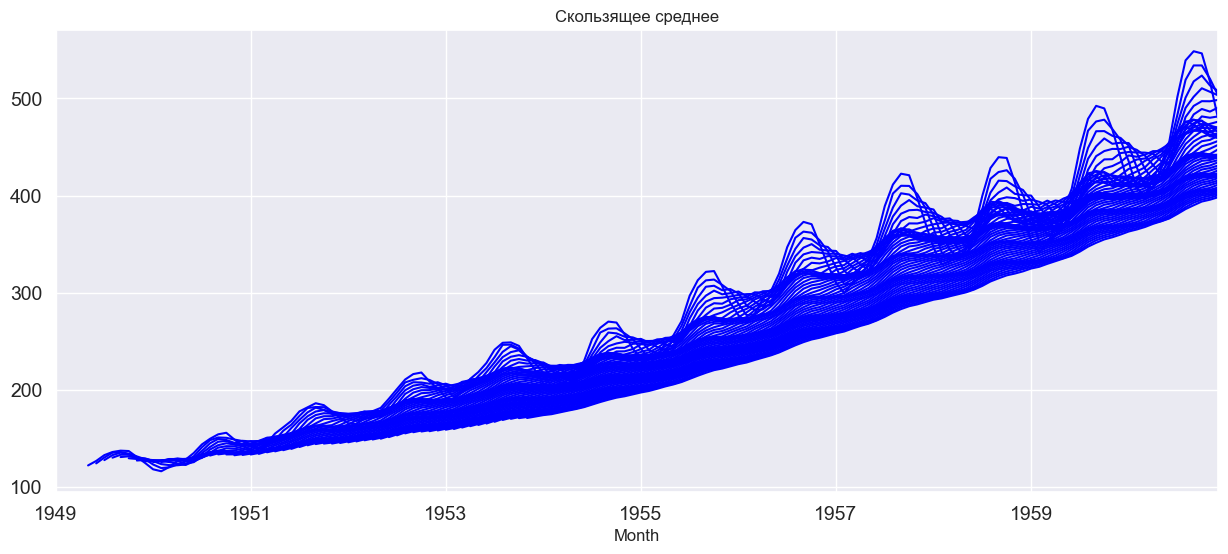

In [96]:
for i in range(5, 60):
    MA = df.passengers.rolling(window=i).mean()
    MA.plot( figsize=(15,6),title= 'Скользящее среднее', fontsize=14, color="blue")
plt.show()

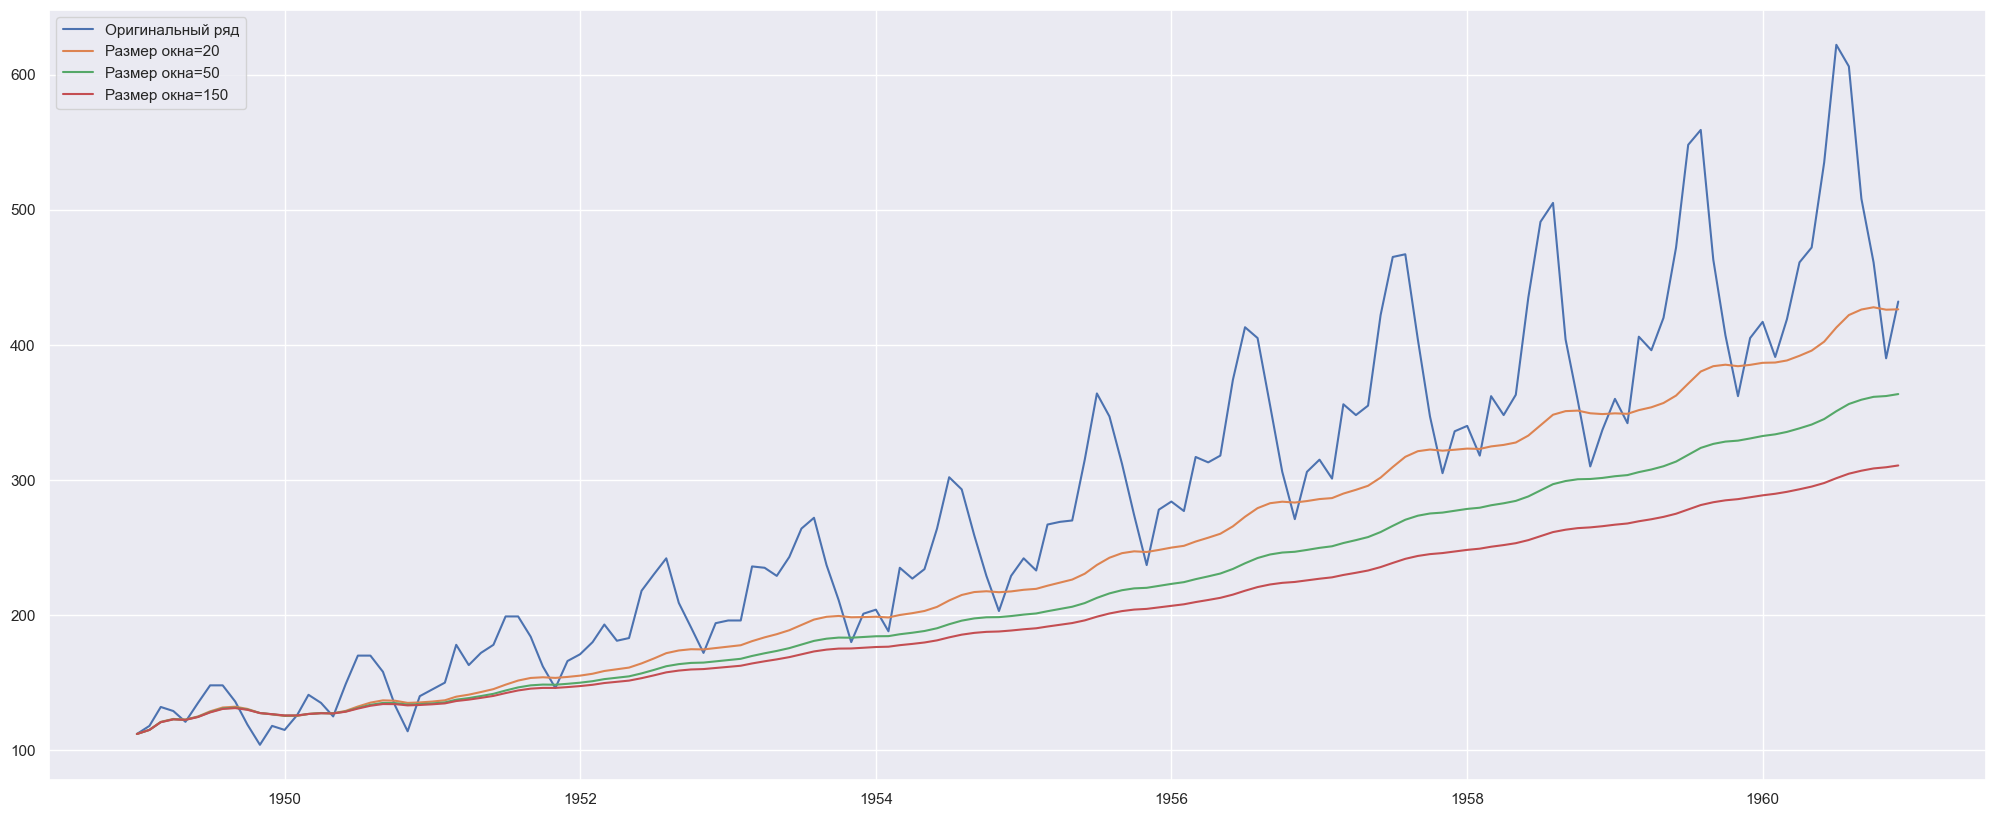

In [97]:
df['ema_20'] = df.passengers.ewm(20).mean()
df['ema_50'] = df.passengers.ewm(50).mean()
df['ema_150'] = df.passengers.ewm(150).mean()
plt.figure(figsize=(25,10))
plt.plot(df.passengers, label='Оригинальный ряд')
plt.plot(df.ema_20, label='Размер окна=20')
plt.plot(df.ema_50, label='Размер окна=50')
plt.plot(df.ema_150, label='Размер окна=150')

plt.legend()

**Вывод:**

Наблюдается постепенно увеличивающийся общий тренд если не вдоваться в подробности сезонности

#### 6. Анализ шума

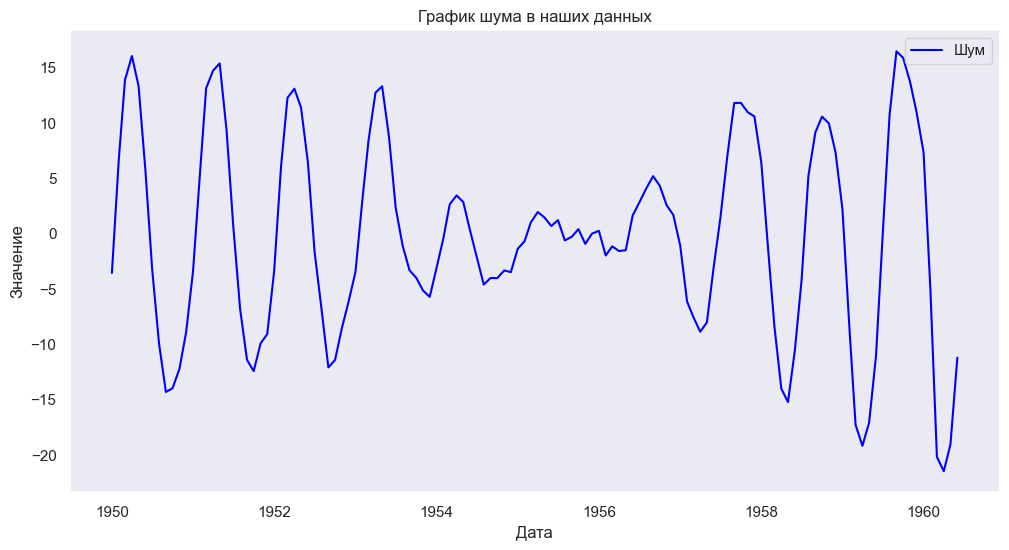

In [98]:
noise = decomposition.resid

plt.figure(figsize=(12, 6))
plt.plot(noise.index, noise, label='Шум', color='blue')
plt.title('График шума в наших данных')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.grid()
plt.show()

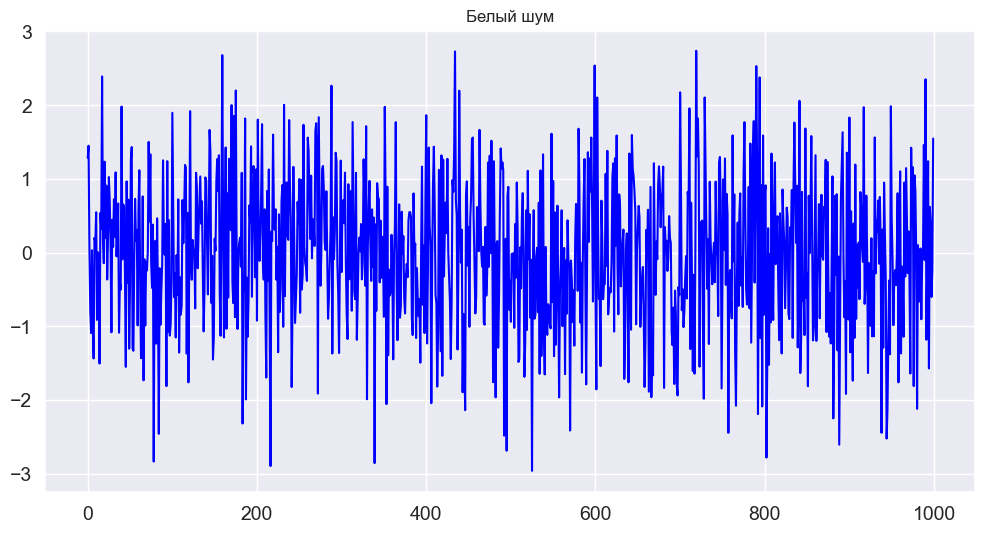

In [99]:
from random import gauss, seed

seed(1)
series = [gauss(0.0, 1.0) for i in range(1000)]
series = pd.Series(series)

series.plot( figsize=(12, 6),title= 'Белый шум', fontsize=14, color="blue")
plt.show()

##### Выводы:
  Шум в данных в отличие от белого шума имеет определенную структуру, и я думаю это может указывать на то что в данных присутствуют другие компоненты, что то вроде тренда и сезонности которые не были учтены.

#### 7. Декомпозиция временного ряда

Text(0, 0.5, 'шум')

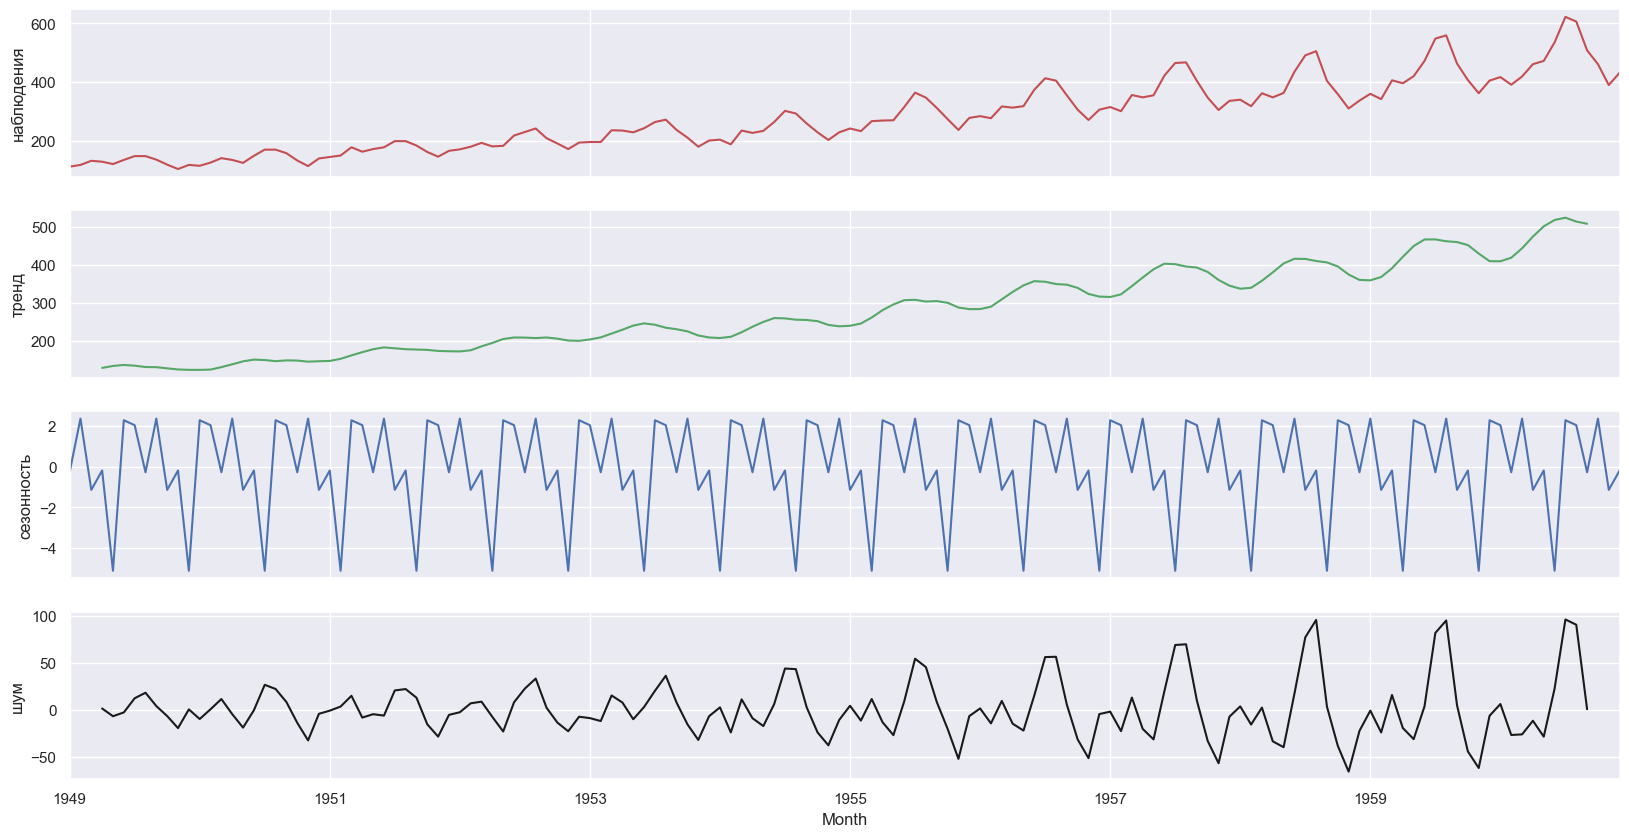

In [110]:
import statsmodels.api as sm
plt.rcParams['font.size'] = 14
plt.rcParams["figure.figsize"] = (20, 10)

res = sm.tsa.seasonal_decompose(df.passengers, model='additive', period= 7)
fig, axes = plt.subplots(4, 1, sharex=True)

res.observed.plot(ax=axes[0], legend=False, color='r')
axes[0].set_ylabel('наблюдения')
res.trend.plot(ax=axes[1], legend=False, color='g')
axes[1].set_ylabel('тренд')
res.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('сезонность')
res.resid.plot(ax=axes[3], legend=False, color='k')
axes[3].set_ylabel('шум')

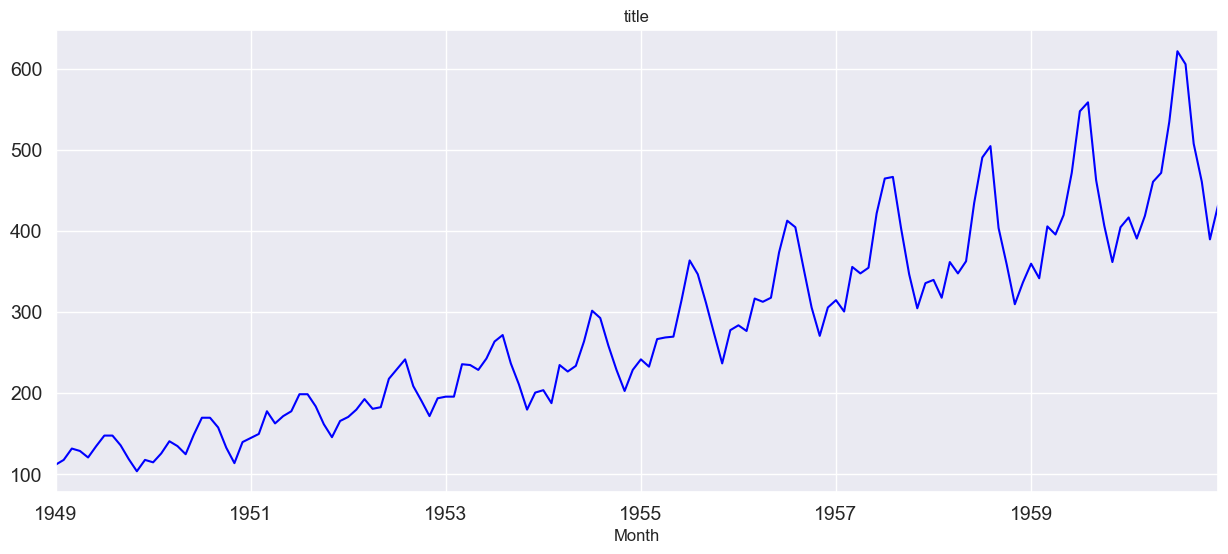

In [111]:
df.passengers.plot( figsize=(15,6),title= 'title', fontsize=14, color="blue")
plt.show()

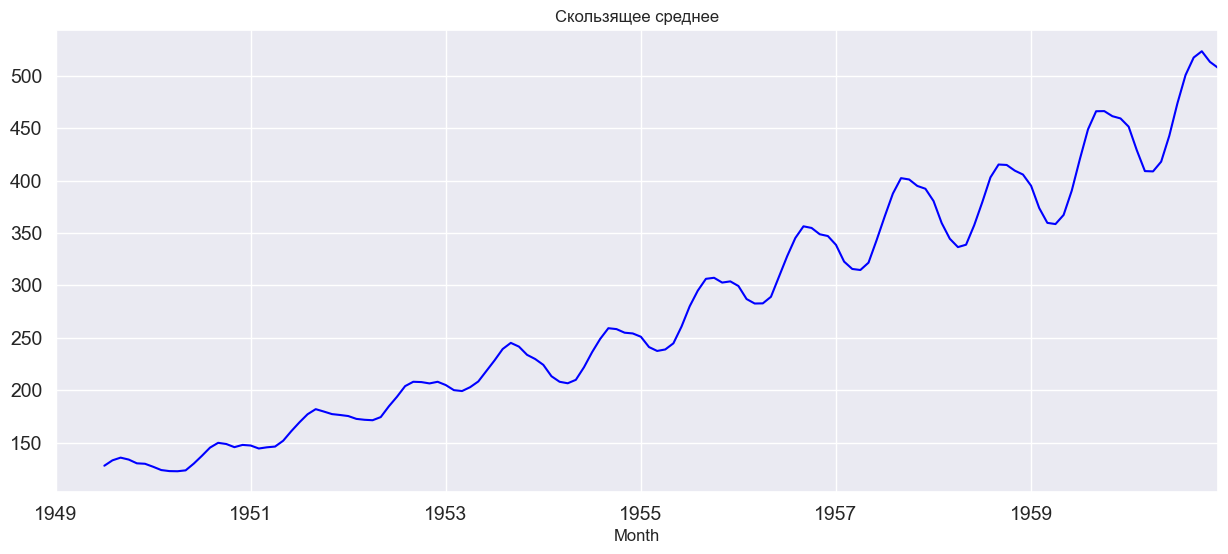

In [117]:
MA = df.passengers.rolling(window=7).mean()
MA.plot( figsize=(15,6),title= 'Скользящее среднее', fontsize=14, color="blue")
plt.show()

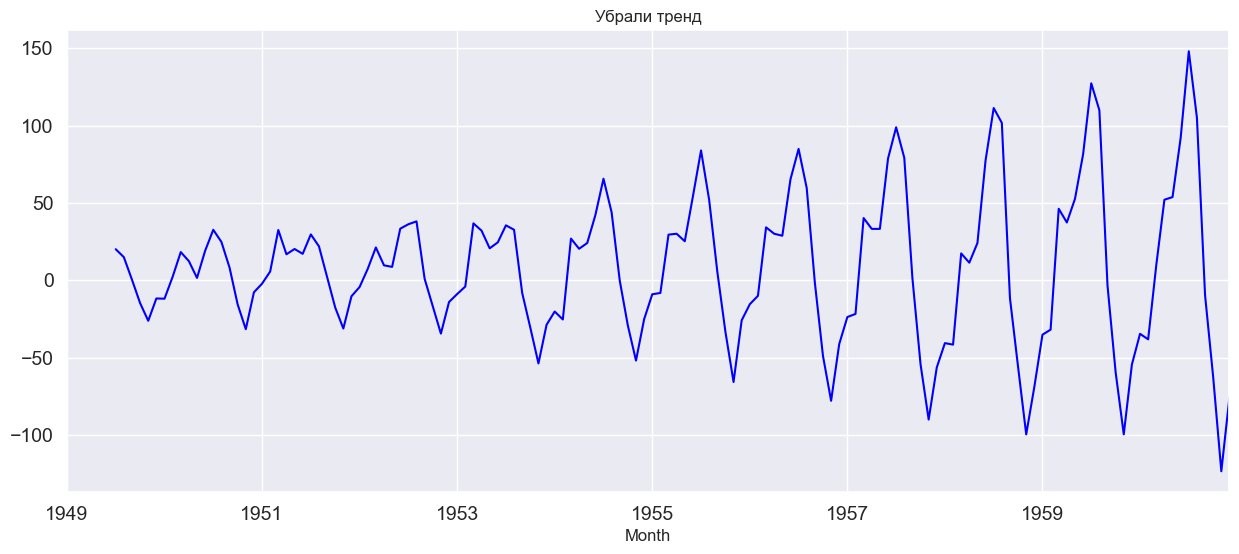

In [118]:
detrend_ = df.passengers - MA
detrend_.plot( figsize=(15,6),title= 'Убрали тренд', fontsize=14, color="blue")
plt.show()

In [126]:
from pandas.core.nanops import nanmean as pd_nanmean

def season_mean(x, period):
    x = np.asarray(x)
    return np.array([pd_nanmean(x[i::period], axis=0) for i in range(period)])

In [129]:
s_a = season_mean(detrend_, 7)
s_a -= np.mean(s_a, axis=0)

nobs = detrend_.shape[0]
seasonal = np.tile(s_a.T, nobs // 7 + 1).T[:nobs]

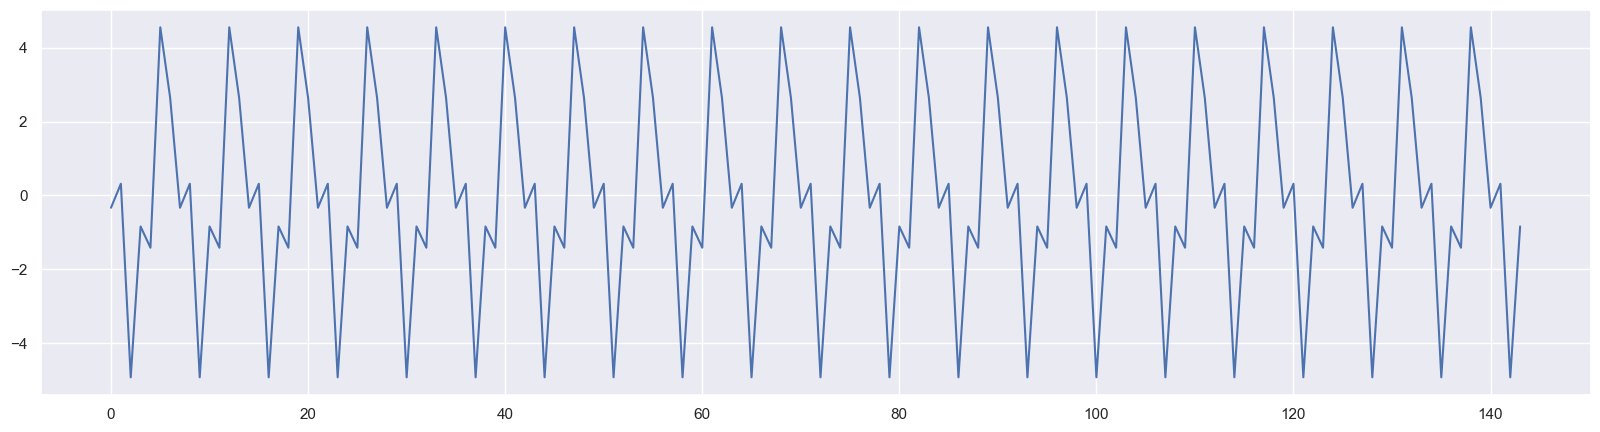

In [130]:
plt.figure(figsize=(20,5))
plt.plot(seasonal)
plt.show()

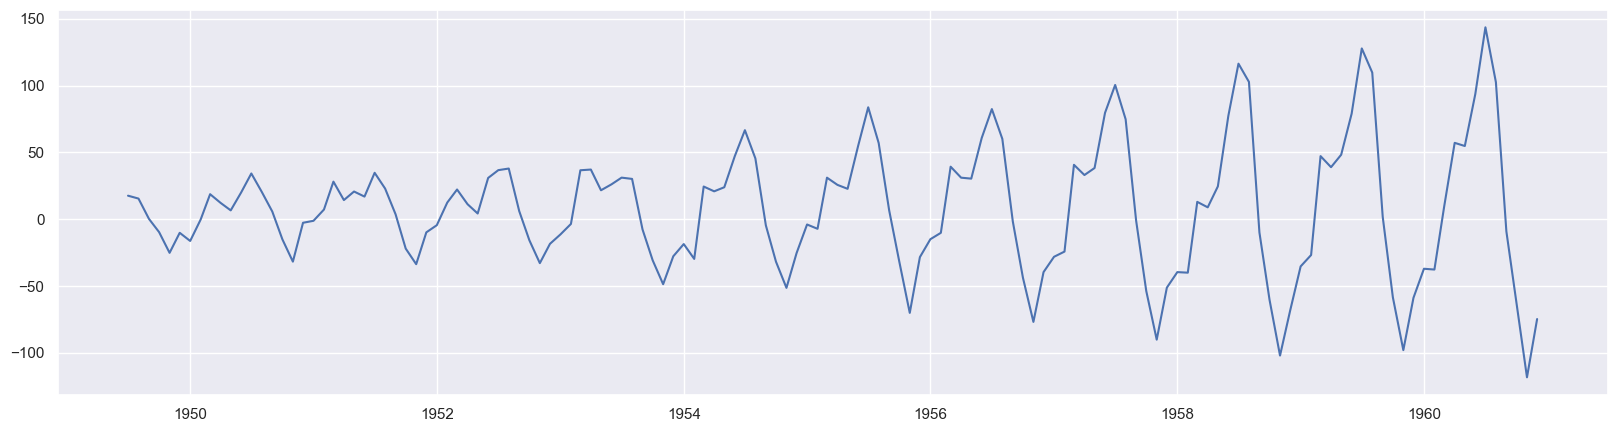

In [132]:
residuals = df.passengers - MA - seasonal

plt.figure(figsize=(20,5))
plt.plot(residuals)
plt.show()

Text(0.5, 1.0, 'Исходный ряд')

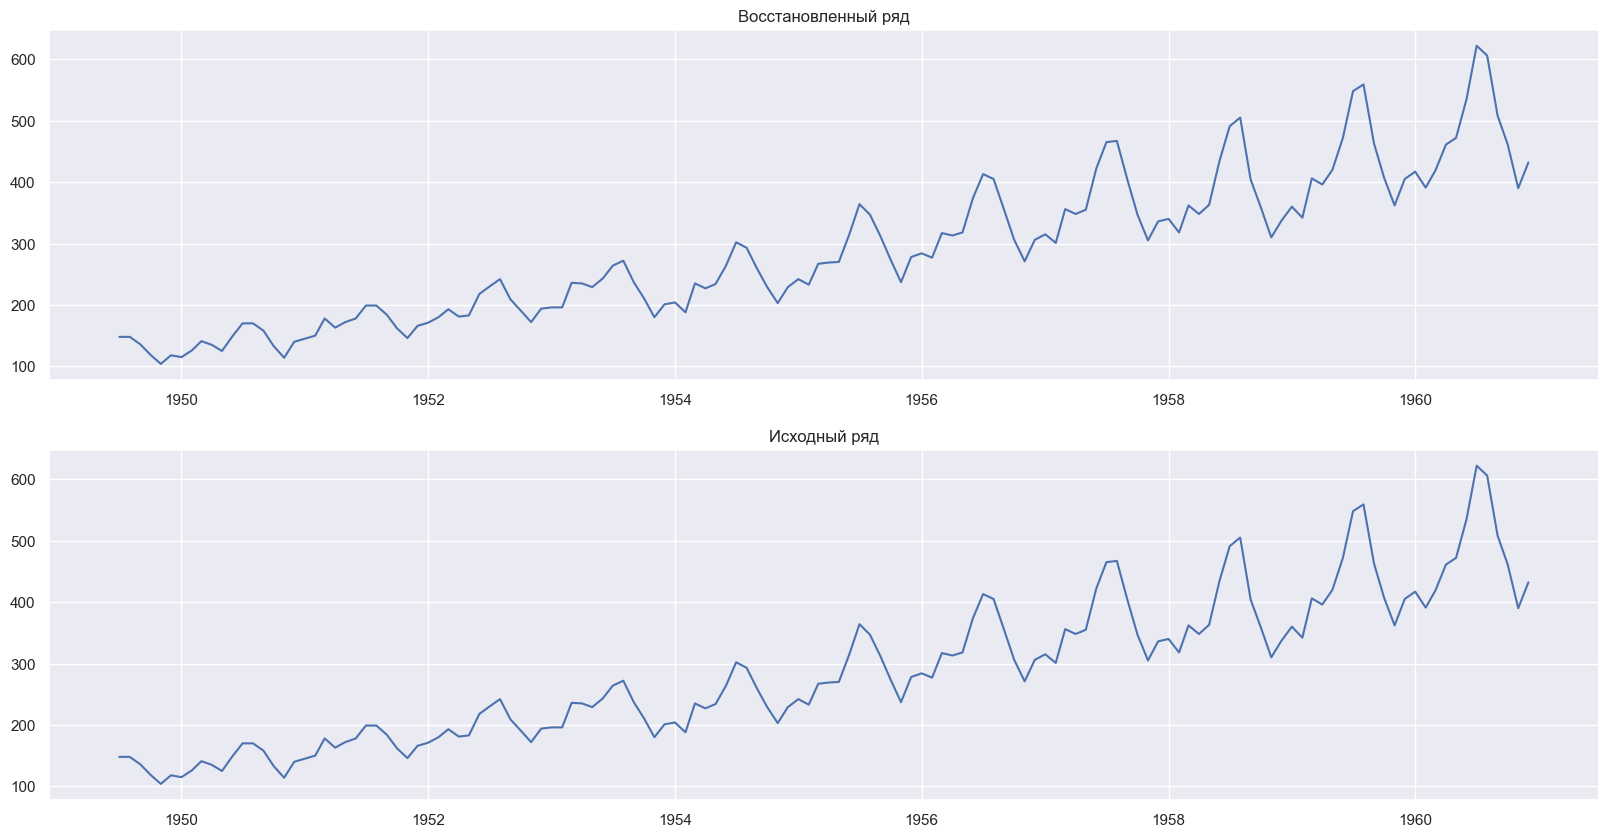

In [133]:
fig, ax = plt.subplots(2, 1, figsize=(20,10))

ax[0].plot(MA + residuals + seasonal)
ax[0].set_title('Восстановленный ряд')
ax[1].plot(df.passengers[MA.dropna().index[0]:])
ax[1].set_title('Исходный ряд')


В обоих случаях графики почти одинаковы за исключением застянутости при ручной декомпозиции. А так тренд и сезонность наблюдаются в обоих случаях

#### 8. Построение графика автокорреляции

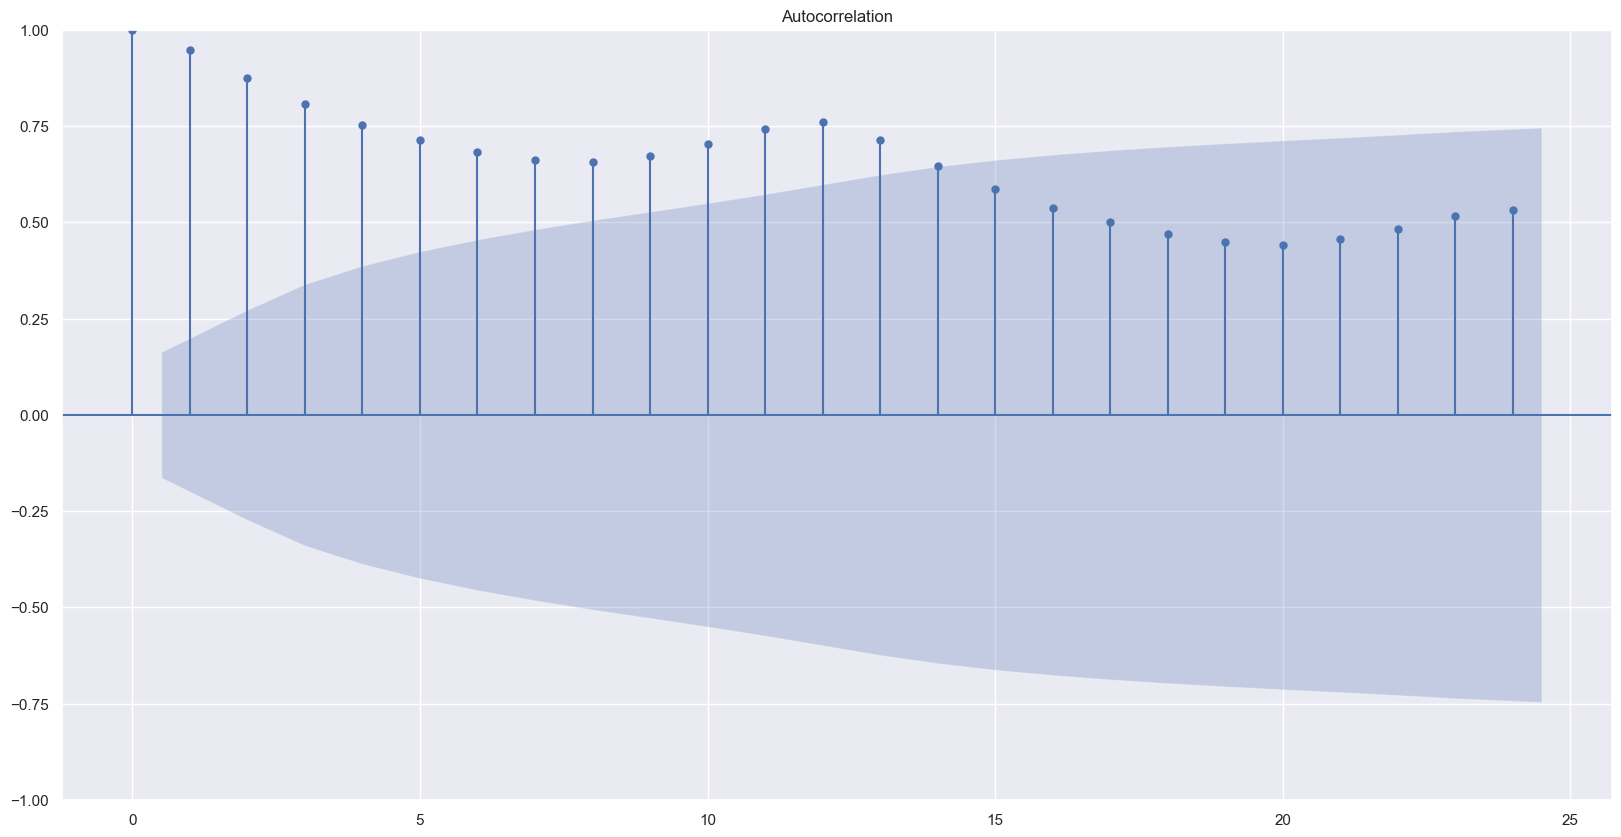

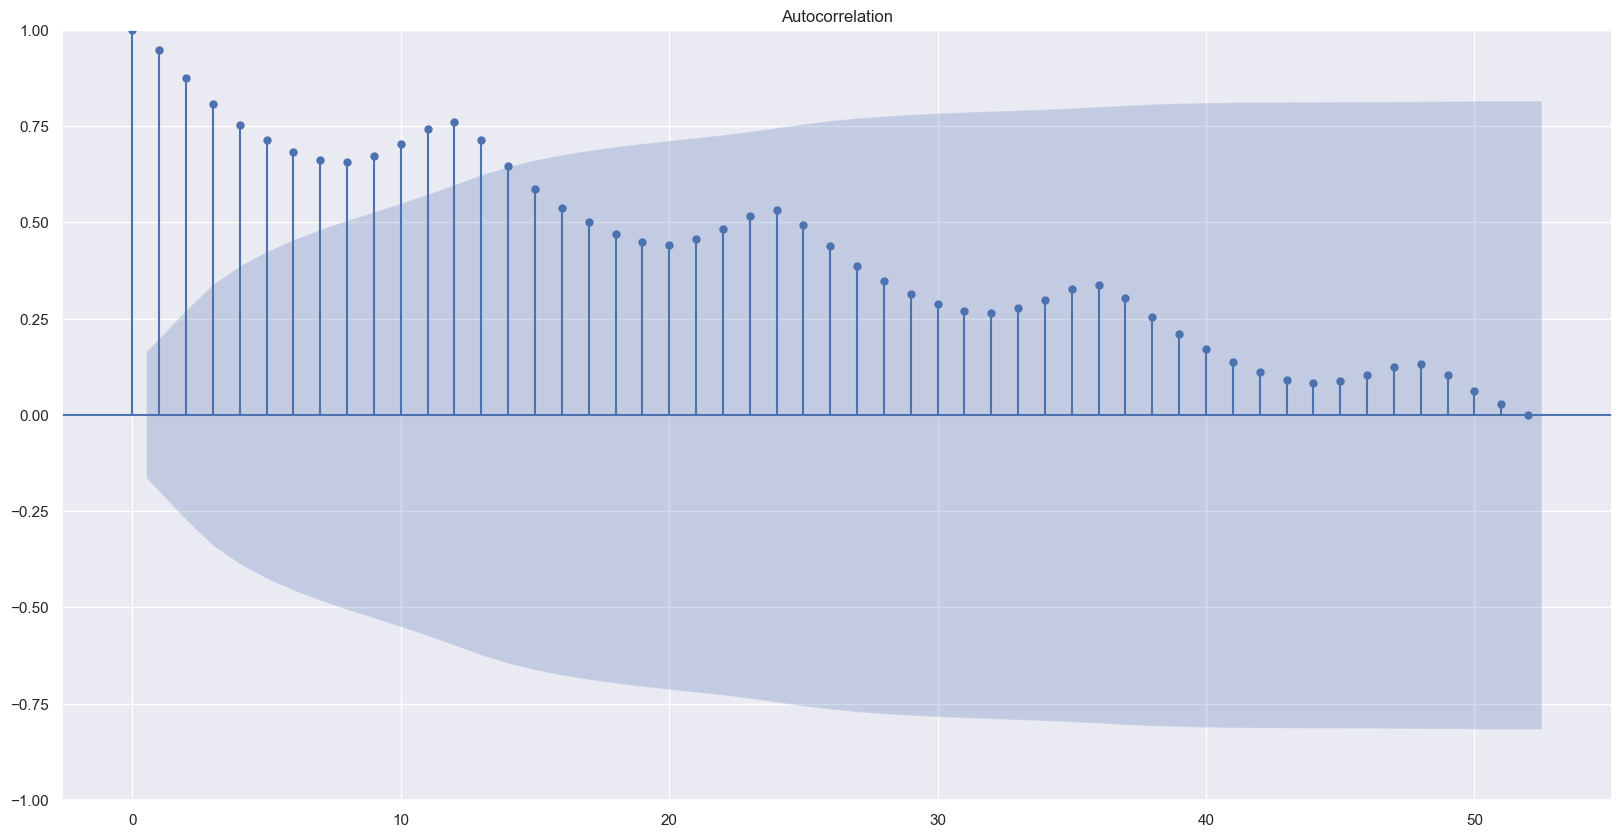

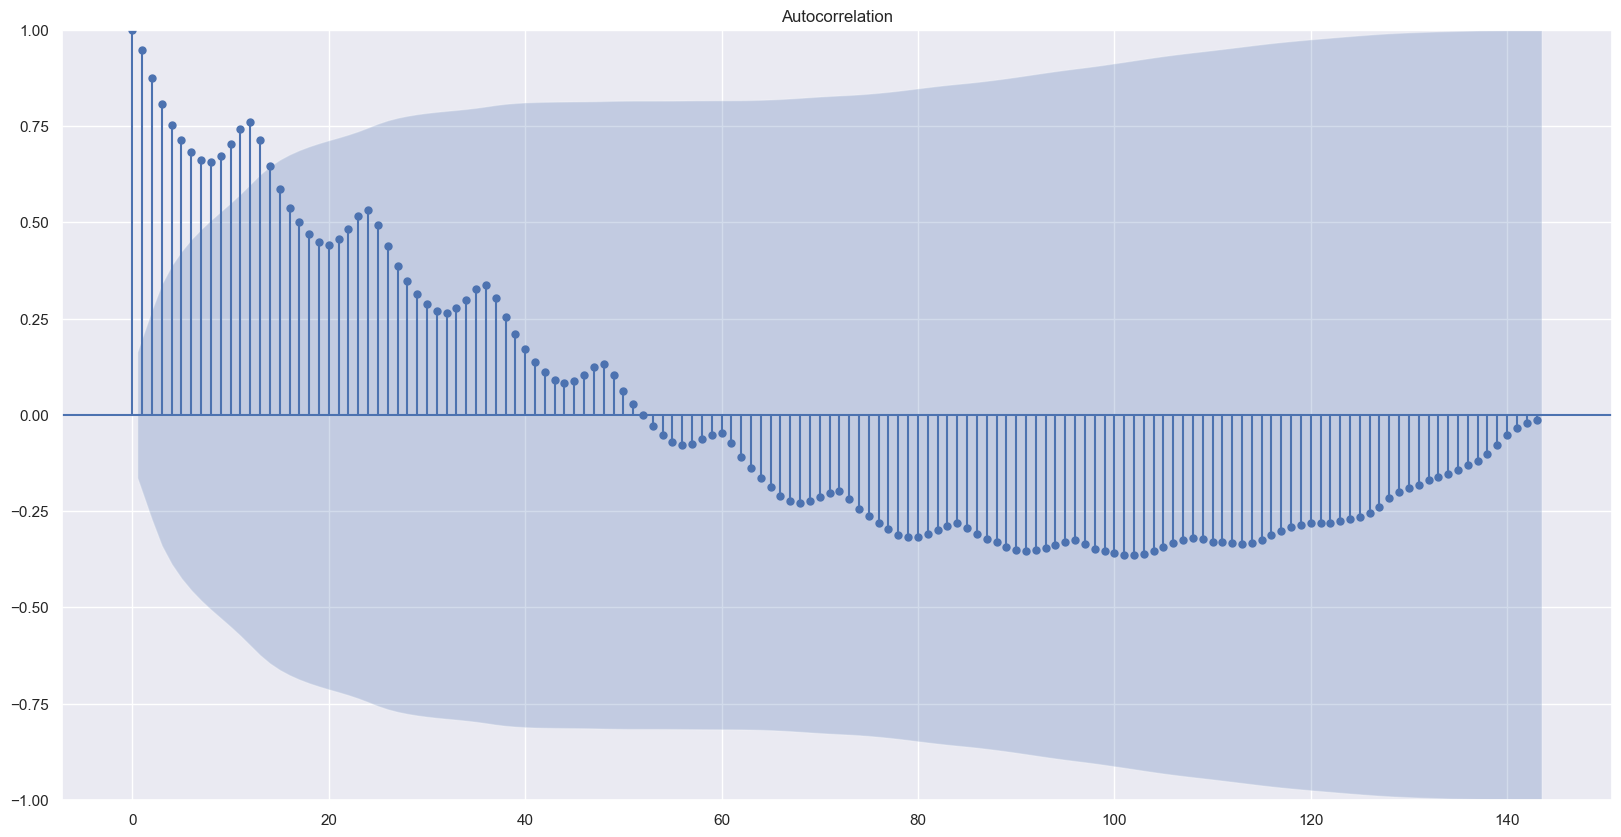

In [151]:
from statsmodels.graphics.tsaplots import plot_acf

for i in [24, 52, 143]:
    plot_acf(df.passengers.values, lags=i)


Видно что зависимость между ближайшими соседями имеется, и она то уменьшается то увеличивается через определенное кол. значений, что наводит на мысль о переодичности и цикличности в данных. Это говорит о возможном выявлении сезонности в данных.
Спускается на 9 соседей (низшая точка в первом цикле), и возрастает до следующий 4х соседей. acf уменьшается с 1 до 0.67-0.68, и увеличивается с 0.67 до 0.76 (приблизительно).-0.32, потом +0.11. Данный процесс повторяется и говорит нам об явном существовании **сезонности**
На 52-ом лаге значение acf снижается с 1 до 0.

# The End